In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats, glob, os, random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 20 positions version

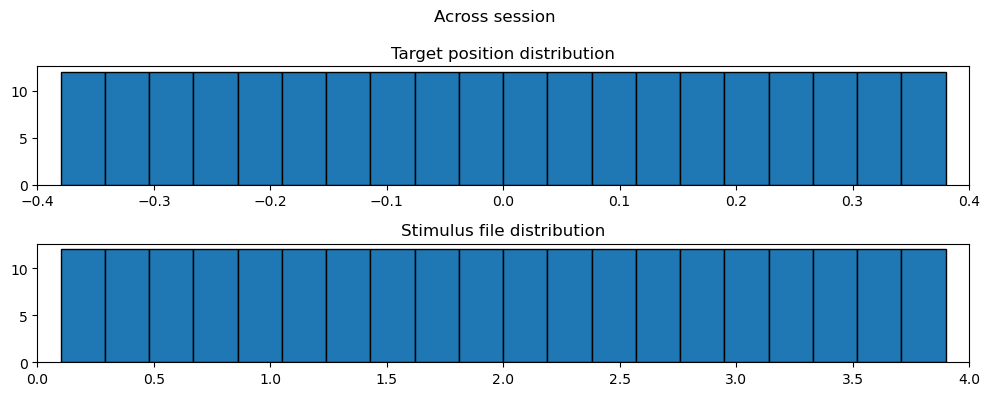

In [2]:
trial_info, trial_key, blockN = [], 0, 0

for run in [1,2]:

    for div in [0, -.2, .2]:
        
        blockN += 1

        # 1. sample 40 positions based on divider
        if div == 0:
            stim_file_pos_ls = np.round( np.sort( np.tile( np.arange(.1, 4.0, .2), 2 ) ), 1)
            
        elif div == -.2:
            stim_file_pos_ls = np.round( np.sort( np.tile( np.concatenate( [ np.arange(.1, 1.0, .2), np.arange(.1, 1.0, .2), np.arange(1.1, 3.0, .2) ] ), 2 ) ), 1)

        elif div == .2:
            stim_file_pos_ls = np.round( np.sort( np.tile( np.concatenate([ np.arange(1.1, 3.0, .2), np.arange(3.1, 4.0, .2), np.arange(3.1, 4.0, .2) ] ), 2 ) ), 1)

        # 2. sample valence display order
        # disp_val_ls = ['pen_rew', 'rew_pen'] * 20
        shape_order_ls = ['curv_flat', 'flat_curv'] * 20

        # 3. sample noise
        noise_pos_ls = [0.0] * 20 + [4.0] * 20 if run == 1 else [4.0] * 20 + [0.0] * 20

        # 4. sample marker: 50-50 on right-left for each target category
        marker_dir = [-1, -1, 1, 1] * 40

        for i in range(len(stim_file_pos_ls)):
            
            # set some vars outside the loop
            stim_pos = round((stim_file_pos_ls[i] - 2) * .2, 2)
            target_pos = stim_pos if shape_order_ls[i] == 'curv_flat' else -stim_pos
            
            if marker_dir[i] < 0:
                marker = random.uniform(-.4, div)
                while not .01 < abs(target_pos-marker) <= .6: # not too close or far
                    marker = random.uniform(-.4, div)

            elif marker_dir[i] > 0:
                marker = random.uniform(div, .4)
                while not .05 < abs(target_pos-marker) <= .6: # not too close or far
                    marker = random.uniform(div, .4)

            img_prefix = 'input_data/stims/Shape_'

            # reminder: stim_file_pos (0,4), stim_pos (-.4,.4), target (-.4,.4)
            trial_info.append({
                    'blockN': blockN,
                    'run': run,
                    'condition': 'baseline' if div == 0 else 'pen_comp' if div == -.2 else 'rew_comp',
                    'trial_key': trial_key,

                    'stim_file_pos': stim_file_pos_ls[i],
                    'stim_pos': stim_pos,
                    'noise_pos': noise_pos_ls[i],
                    'marker': marker,
                    'shape': 'curv' if stim_pos <= div else 'flat',

                    'shape_order': shape_order_ls[i],
                    'div_pos': div if shape_order_ls[i] == 'curv_flat' else -div,
                    'target_pos': stim_pos if shape_order_ls[i] == 'curv_flat' else -stim_pos,

                    'subj_C0F1_val': 'pen' if stim_pos <= div else 'rew',
                    'subj_C1F0_val': 'rew' if stim_pos <= div else 'pen',                    

                    'target_file': f'{img_prefix}{stim_file_pos_ls[i]}0_{noise_pos_ls[i]}0.png',
                    'img1_file': f'{img_prefix}0.00_{noise_pos_ls[i]}0.png' if shape_order_ls[i] == 'curv_flat'\
                            else f'{img_prefix}4.00_{noise_pos_ls[i]}0.png',
                    'img2_file': f'{img_prefix}4.00_{noise_pos_ls[i]}0.png' if shape_order_ls[i] == 'curv_flat'\
                            else f'{img_prefix}0.00_{noise_pos_ls[i]}0.png'
                    })
            
            trial_key += 1

            
df = pd.DataFrame(trial_info)
# if file doesnt exist, then create
df.to_csv('../input_data/trials.csv', index=False)

# across-session plot
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
fig.suptitle('Across session')

ax = axs[0]
ax.hist(df['target_pos'], bins=20, edgecolor='black')
ax.set_title('Target position distribution')
ax.set_xlim(-.4, .4)

ax = axs[1]
ax.hist(df['stim_file_pos'], bins=20, edgecolor='black')
ax.set_title('Stimulus file distribution')
ax.set_xlim(.0, 4)

plt.tight_layout()
plt.show()


## noise-free or noised plot by divider

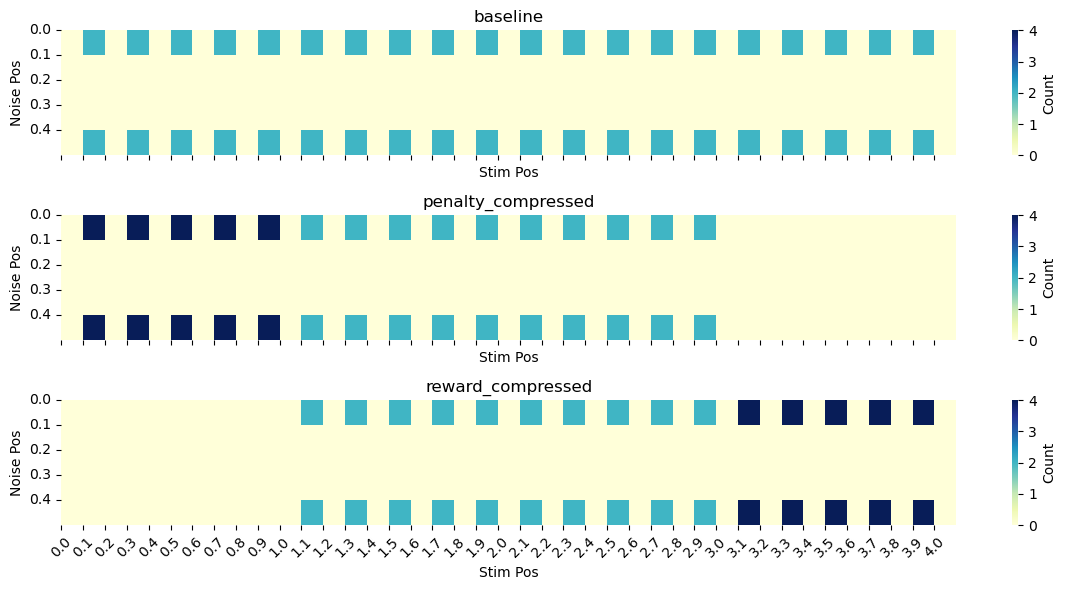

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), sharex=True)
comp_labels = ['baseline', 'penalty_compressed', 'reward_compressed']

# loop through dividers
for j, div in enumerate([.0, -.2, .2]):
    
    df_run_div = df[df['div'] == div]
    ax = axs[j]

    # 1. plot noised version

    heatmap_data = np.zeros((5, 41))        
    for _, trial in df_run_div.iterrows():
        heatmap_data[int(trial['noise_pos']), int(10*trial['stim_file_pos'])] += 1

    sns.heatmap(heatmap_data, cmap="YlGnBu", ax=ax, 
                vmin=0, vmax=4,
                cbar_kws={
                    'label': 'Count',
                    'ticks': [0, 1, 2, 3, 4]
                })
    
    ax.set_title(f'{comp_labels[j]}')
    ax.set_xlabel('Stim Pos')
    ax.set_ylabel('Noise Pos')
    
    noise_ticks = np.arange(0, 5, 1)
    ax.set_yticks(noise_ticks)
    ax.set_yticklabels([str(i/10) for i in noise_ticks])
    ax.tick_params(axis='y', labelrotation=0)

    stim_ticks = np.arange(0, 41, 1)
    ax.set_xticks(stim_ticks)
    ax.set_xticklabels([str(i/10) for i in stim_ticks])
    ax.tick_params(axis='x', labelrotation=45)

    # 2. plot noise-less version

    # sns.histplot(df_run_div['target_pos'], bins=41, binrange=(-.4, .4), ax=ax)
    # ax.set_title(f'run: {run}, div: {div}')
    # ax.set_ylim(0, 10)

plt.tight_layout()
plt.show()


## plot each block

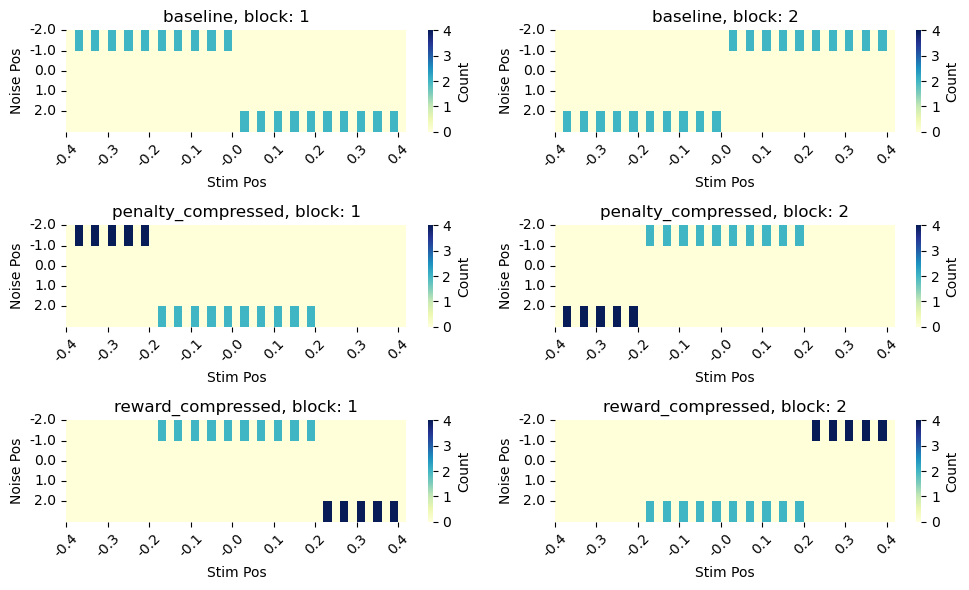

In [68]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))

# loop through runs & dividers
for i, run in enumerate([1, 2]):
    for j, div in enumerate([.0, -.2, .2]):
        
        df_run_div = df[(df['run'] == run) & (df['div'] == div)]
        ax = axs[j, i]


        # 1. plot noised version

        heatmap_data = np.zeros((5, 41))        
        for _, trial in df_run_div.iterrows():
            heatmap_data[int(trial['noise_pos']), int(10*trial['stim_file_pos'])] += 1

        sns.heatmap(heatmap_data, cmap="YlGnBu", ax=ax, 
                    vmin=0, vmax=4,
                    cbar_kws={
                        'label': 'Count',
                        'ticks': [0, 1, 2, 3, 4]
                    })
        
        ax.set_title(f'{comp_labels[j]}, block: {run}')
        
        ax.set_xlabel('Stim Pos')
        ax.set_xticks(np.arange(0, 41, 5))  
        ax.set_xticklabels([f'{x:.1f}' for x in np.arange(-0.4, 0.5, 0.1)])  
        ax.tick_params(axis='x', labelrotation=45)

        ax.set_ylabel('Noise Pos')
        ax.set_yticks(np.arange(0, 5, 1))  
        ax.set_yticklabels([f'{y:.1f}' for y in np.arange(-2, 2.1, 1)])  
        ax.tick_params(axis='y', labelrotation=0)

        # 2. plot noise-less version

        # sns.histplot(df_run_div['stim_pos'], bins=41, binrange=(-.4, .4), ax=ax)
        # ax.set_xlabel('Stimulus position programmed')
        # # sns.histplot(df_run_div['target_pos'], bins=41, binrange=(-.4, .4), ax=ax)
        # # ax.set_xlabel('Stimulus position seen by subject')

        # ax.set_title(f'block: {run}, {comp_labels[j]}')
        # ax.set_ylim(0, 5)
        # ax.axvline(x=div, color='red', linestyle='--')
        # # ax.axvline(x=-div, color='red', linestyle='--')
        # if i == 0 and j == 0:
        #     ax.legend(['divider'], loc='upper right')

plt.tight_layout()
plt.show()

## histogram of trial-ease

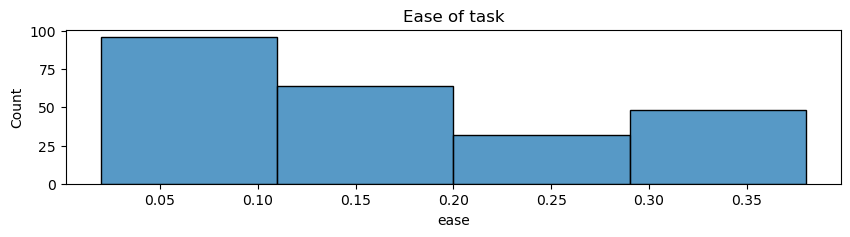

Proportion of trials where ease <= .1: 0.3333333333333333


KeyError: 'valence'

In [12]:
df['ease'] = abs(df['target_pos'] - df['disp_div'])
plt.figure(figsize=(10, 2))
sns.histplot(df['ease'], bins=4)
plt.title('Ease of task')
plt.show()

print(f"Proportion of trials where ease <= .1: {len(df[df['ease'] <= .1]) / len(df)}")
print(df['valence'].value_counts())
print(df['valence_disp'].value_counts())

In [ ]:
        # if div == 0:
        #     noise_pos_ls = [2.0] * 10  +  [0.0,4.0] * 10  +  [2.0] * 10 
        # elif div == -.2:
        #     noise_pos_ls = [2.0] * 10  +  [0.0,4.0] * 10  +  [2.0] * 10 if run == 1 else [2.0] * 10  +  [4.0,0.0] * 10  +  [2.0] * 10
        #     print(noise_pos_ls)
        # elif div == .2:
        #     noise_pos_ls = [2.0] * 10  +  [0.0,4.0] * 10  +  [2.0] * 10 if run == 2 else [2.0] * 10  +  [4.0,0.0] * 10  +  [2.0] * 10



# a1 = [2.0] * 10  +  [0.0] * 20  +  [2.0] * 10 
# a2 = [2.0] * 10  +  [4.0] * 20  +  [2.0] * 10 

# b1 = [2.0] * 5 + [0.0] * 15  +  [2.0] * 20
# b2 = [2.0] * 5 + [4.0] * 15  +  [2.0] * 20

# c1 = [2.0] * 20  +  [0.0] * 15  +  [2.0] * 5
# c2 = [2.0] * 20  +  [4.0] * 15  +  [2.0] * 5

# fig, axs = plt.subplots(3, 1, figsize=(4, 6))

# ax = axs[0]
# ax.plot(a1)
# ax.plot(a2)
# ax.set_ylabel('noise')
# ax.set_xlabel('stim')
# ax.axvline(x=20, color='r', linestyle='--')

# ax = axs[1]
# ax.plot(b1)
# ax.plot(b2)
# ax.set_ylabel('noise')
# ax.set_xlabel('stim')
# ax.axvline(x=10, color='r', linestyle='--')

# ax = axs[2]
# ax.plot(c1)
# ax.plot(c2)
# ax.set_ylabel('noise')
# ax.set_xlabel('stim')
# ax.axvline(x=30, color='r', linestyle='--')

# plt.tight_layout()
# plt.show()